<a href="https://colab.research.google.com/github/ivannamal/neural_network/blob/main/Detectron2_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Detector architecture analysis**

Compare YOLOv8, RT-DETR, and Mask R-CNN networks

YOLOv8 — це модель для виявлення об'єктів у реальному часі. У неї 9 млн параметрів, і вона працює дуже швидко.

RT-DETR — використовує трансформери. Є повільнішою за YOLOv8, але дає кращі результати по точності.

Mask R-CNN — це модель для складних задач (напр. інстанс-сегментації). Вона має 44 млн параметрів, працює повільніше і здатна точно виділити форму об'єктів на зображенні.  

У висновку: YOLOv8 — для швидкості, RT-DETR — якщо потрібен баланс, а Mask R-CNN — якщо важлива точність сегментації.

# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

In [ ]:
import io, zipfile, glob, cv2, torch
from google.colab import files
from detectron2.utils.visualizer import ColorMode

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DefaultPredictor(cfg)
metadata  = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])


uploaded = files.upload()
zip_name = next(iter(uploaded))

os.makedirs("imgs", exist_ok=True)
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as zf:
    zf.extractall("imgs")

images = glob.glob("imgs/**/*.jpg", recursive=True) + \
         glob.glob("imgs/**/*.png", recursive=True)

os.makedirs("out", exist_ok=True)
for path in images:
    img = cv2.imread(path)
    outputs = predictor(img)
    vis = Visualizer(img[:, :, ::-1], metadata,
                     scale=1.0, instance_mode=ColorMode.IMAGE)
    vis_img = vis.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()[:, :, ::-1]
    out_path = "out/det_" + os.path.basename(path)
    cv2.imwrite(out_path, vis_img)

!zip -rq detectron2_results.zip out
files.download("detectron2_results.zip")


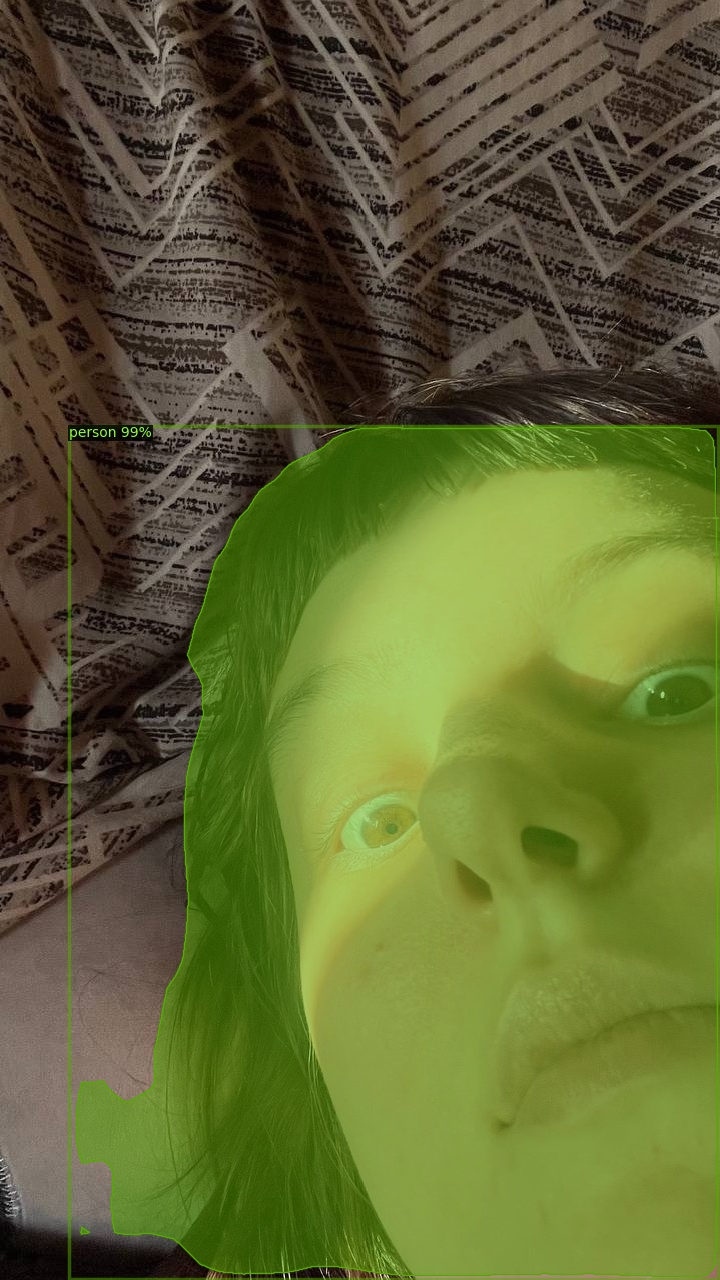

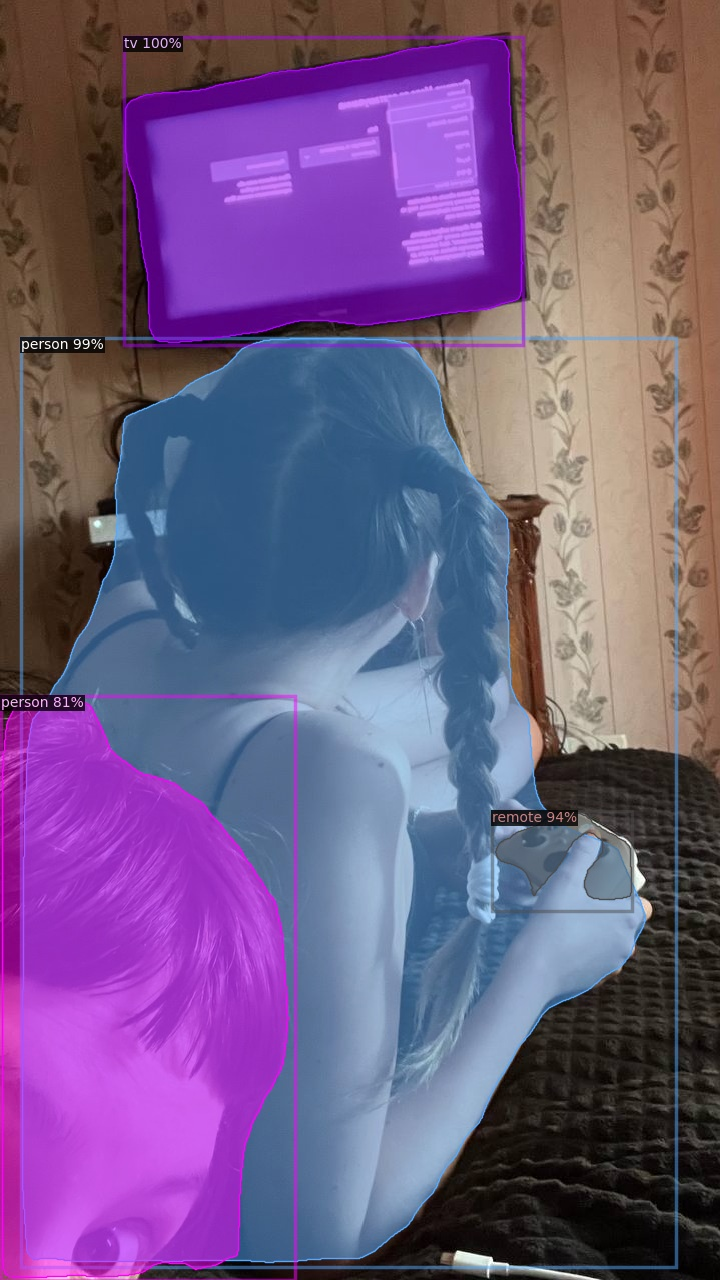

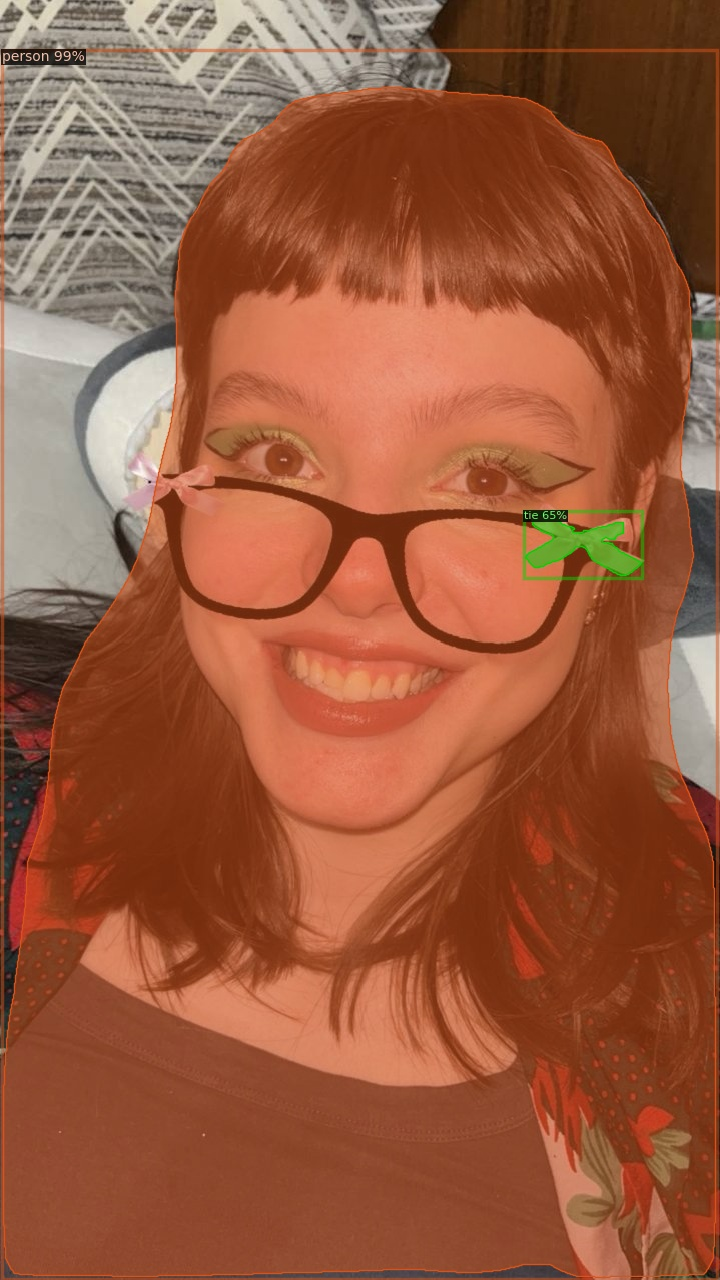

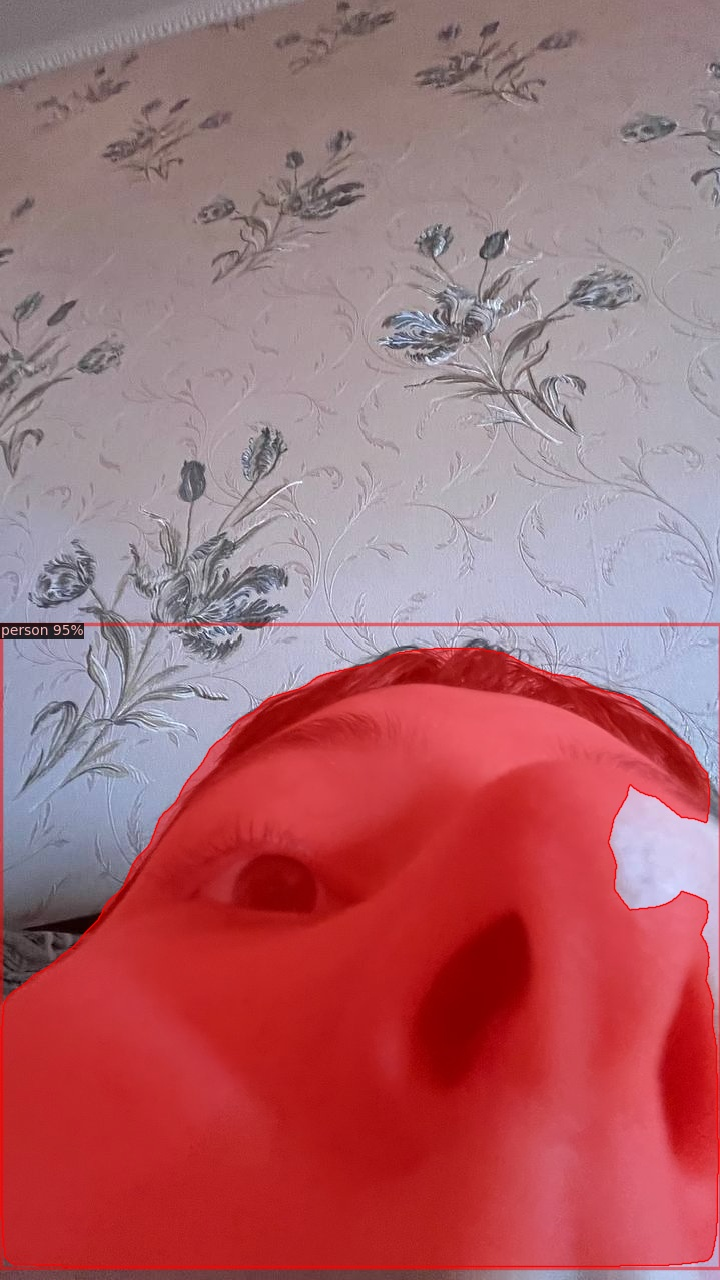

**Did it detect objects correctly, or were there errors?
How did lighting, angles, or clutter affect it?**

Усі об'єкти були розпізнані правильно. 81% - мінімальний відсоток з яким було розпізнано людину, через те, що було видно лише 1/4 її обличчя. У більшості фото розпізнавання людини трималось у межах 95-99%, падаючи до 95%, якщо кут фото був незвичний.